<a href="https://colab.research.google.com/github/parulnith/Demo1/blob/master/Constrained_XGB_and_Post_Hoc_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6: Explainable Boosting Machines and Explaining XGBoost for Consumer Finance

## XGBoost with Constraints and Explainable Artificial Intelligence

## Contents

1. [Constrained and Unconstrained XGBoost](#constrained-and-unconstrained-XGBoost)
    - Prepare data
    - Investigate pairwise Spearman correlations with the target variable
    - Train the models
    - Examine model feature importance values
2. [Explaining Model Behavior with Partial Dependence and ICE](#pdp-ice)
    - Generate PD/ICE plots for constrained and unconstrained models
    - Compare model treatment of individual features
3. [Decision Tree Surrogate Models as an Explanation Technique](#decision-tree-surrogate)
    - Train a surrogate model for the constrained model
    - Assess surrogate model fidelity through cross-validation
    - Visualize surrogate models for the constrained and unconstrained models
4. [Shapley Value Explanations](#shapley)
    - Compute explanations and generate exploratory visualizations
    - Identify observations that get different treatment under different shap parameterizations


## Resources

### Decision Tree Surrogates

1. [Interpretability via Model Extraction](https://github.com/ml-for-high-risk-apps-book/Book-Wiki/blob/main/Resources/Papers/2018_Bastani_InterpreabilityViaModelExtraction.pdf)
2. [Extracting Tree-Structured Representations of Trained Networks](https://github.com/ml-for-high-risk-apps-book/Book-Wiki/blob/main/Resources/Papers/1995_Craven_ExtractingTreeStructRepresentationsOfNetworks.pdf)

### Shapley Value Explanations
1. True to the Model or True to the Data?
2. Feature relevance quantification in explainable AI: A causal problem
3. Problems with Shapley-value-based explanations as feature importance measures

# Setting the environment

Download the [zipped data_and_package folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`.

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip"
%cd /content/Data

/content/Data


In [3]:
%pip install shap
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 33 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## <a name="constrained-and-unconstrained-XGBoost"></a>1. Constrained and Unconstrained XGBoost

### Prepare data

In [5]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')

In [6]:
seed = 12345
np.random.seed(seed)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


In [7]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

dtrain = xgb.DMatrix(train[features], 
                     label=train[target])

dvalid = xgb.DMatrix(valid[features], 
                     label=valid[target])

### Investigate Pairwise Spearman Correlations with the Target Variable

Use Spearman correlation (rather than Pearson) because XGBoost's monotonic constraints still handle nonlinear relationships between the variable and the target. See [the XGBoost tutorial on monotonic constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html), as well as the text.


In [8]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]
corr.columns = ['Spearman Correlation Coefficient']
corr

,Spearman Correlation Coefficient
LIMIT_BAL,-0.167321
PAY_0,0.288930
PAY_2,0.212779
PAY_3,0.191448
PAY_4,0.169851
PAY_5,0.155790
PAY_6,0.140604
BILL_AMT1,-0.026095
BILL_AMT2,-0.016209
BILL_AMT3,-0.015338


### Automatically Choose Monotonic Constraints

In [9]:
def get_monotone_constraints(data, target, corr_threshold):
    """Calculate monotonic constraints.
    
    Using a cutoff on Spearman correlation between features and target, return a tuple ready to pass into XGBoost. 

    
    Args:
        data (pd.DataFrame): A DataFrame containing the features in the order they appear to XGBoost, as well as the target variable.
        target (str): The name of the column with the target variable in 'data'.
        corr_threshold (float): The Spearman correlation threshold.

    Returns:
        tuple: A tuple with values in {-1, 0, 1}, where each element corresponds to a column in data (excluding the target itself). Ready to pass into xgb.train()

    """
    
    corr = pd.Series(data.corr(method='spearman')[target]).drop(target)
    monotone_constraints = tuple(np.where(corr < -corr_threshold, 
                                          -1, 
                                          np.where(corr > corr_threshold,
                                                   1, 
                                                   0)))
    return monotone_constraints

correlation_cutoff = 0.1

monotone_constraints = get_monotone_constraints(train[features+[target]],
                                                target,
                                                correlation_cutoff)

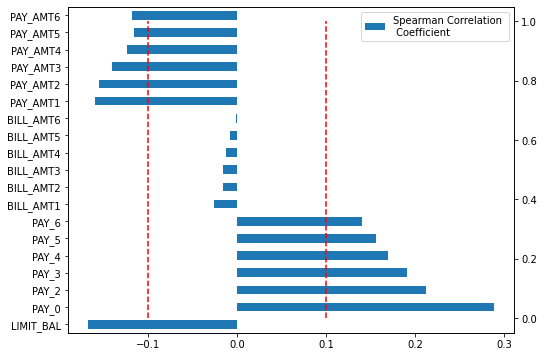

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax2 = ax.twinx()
ax2.vlines([correlation_cutoff, -correlation_cutoff],
           ymin=ax2.get_ylim()[0],
           ymax=ax2.get_ylim()[1],
           colors='red',
           linestyles='dashed')
corr.plot(kind='barh', ax=ax)
_ = ax.legend(['Spearman Correlation \n Coefficient'])

### Train the Unconstrained and Constrained Models

In [11]:
# Feed the model the global bias
base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_unconstrained = xgb.train(params,         
                                dtrain,                   
                                num_boost_round=200,                     
                                evals=watchlist,
                                early_stopping_rounds=10,
                                verbose_eval=True)

[0]	train-auc:0.73140	eval-auc:0.71219
[1]	train-auc:0.77141	eval-auc:0.76254
[2]	train-auc:0.77353	eval-auc:0.76276
[3]	train-auc:0.77380	eval-auc:0.76248
[4]	train-auc:0.77676	eval-auc:0.76676
[5]	train-auc:0.77878	eval-auc:0.77028
[6]	train-auc:0.77974	eval-auc:0.77050
[7]	train-auc:0.78044	eval-auc:0.77186
[8]	train-auc:0.78103	eval-auc:0.77217
[9]	train-auc:0.78361	eval-auc:0.77458
[10]	train-auc:0.78515	eval-auc:0.77487
[11]	train-auc:0.78531	eval-auc:0.77494
[12]	train-auc:0.78597	eval-auc:0.77441
[13]	train-auc:0.78688	eval-auc:0.77485
[14]	train-auc:0.78731	eval-auc:0.77454
[15]	train-auc:0.78803	eval-auc:0.77539
[16]	train-auc:0.78845	eval-auc:0.77562
[17]	train-auc:0.78928	eval-auc:0.77589
[18]	train-auc:0.79031	eval-auc:0.77631
[19]	train-auc:0.79058	eval-auc:0.77691
[20]	train-auc:0.79106	eval-auc:0.77677
[21]	train-auc:0.79201	eval-auc:0.77738
[22]	train-auc:0.79275	eval-auc:0.77804
[23]	train-auc:0.79320	eval-auc:0.77839
[24]	train-auc:0.79390	eval-auc:0.77839
[25]	train

In [13]:
params_constrained = params.copy()
params_constrained['monotone_constraints'] = dict(zip(features, monotone_constraints))
#params_constrained['monotone_constraints'] = monotone_constraints

model_constrained = xgb.train(params_constrained,         
                              dtrain,                   
                              num_boost_round=200,                     
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=True)

[0]	train-auc:0.72741	eval-auc:0.71418
[1]	train-auc:0.76658	eval-auc:0.76171
[2]	train-auc:0.77159	eval-auc:0.76327
[3]	train-auc:0.77160	eval-auc:0.76248
[4]	train-auc:0.77461	eval-auc:0.76764
[5]	train-auc:0.77806	eval-auc:0.77185
[6]	train-auc:0.77814	eval-auc:0.77220
[7]	train-auc:0.77861	eval-auc:0.77274
[8]	train-auc:0.77879	eval-auc:0.77317
[9]	train-auc:0.77941	eval-auc:0.77482
[10]	train-auc:0.78095	eval-auc:0.77636
[11]	train-auc:0.78091	eval-auc:0.77641
[12]	train-auc:0.78117	eval-auc:0.77624
[13]	train-auc:0.78125	eval-auc:0.77613
[14]	train-auc:0.78091	eval-auc:0.77607
[15]	train-auc:0.78089	eval-auc:0.77603
[16]	train-auc:0.78127	eval-auc:0.77644
[17]	train-auc:0.78248	eval-auc:0.77721
[18]	train-auc:0.78286	eval-auc:0.77751
[19]	train-auc:0.78292	eval-auc:0.77744
[20]	train-auc:0.78321	eval-auc:0.77731
[21]	train-auc:0.78370	eval-auc:0.77788
[22]	train-auc:0.78371	eval-auc:0.77797
[23]	train-auc:0.78370	eval-auc:0.77786
[24]	train-auc:0.78423	eval-auc:0.77777
[25]	train

### Examine Model Feature Importance Values

In [40]:
scores_constrained = model_constrained.get_score(importance_type='cover')
scores_unconstrained = model_unconstrained.get_score(importance_type='cover')

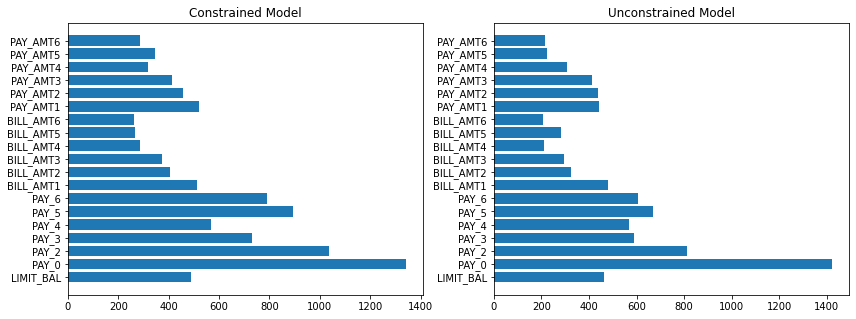

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].barh(list(scores_constrained.keys()), scores_constrained.values())
axs[0].set_title("Constrained Model")

axs[1].barh(list(scores_unconstrained.keys()), scores_unconstrained.values())
_ = axs[1].set_title("Unconstrained Model")

## <a name="pdp-ice"></a>2. Explaining Model Behavior with Partial Dependence and ICE

### Generate PD/ICE Plots for Constrained and Unconstrained Models

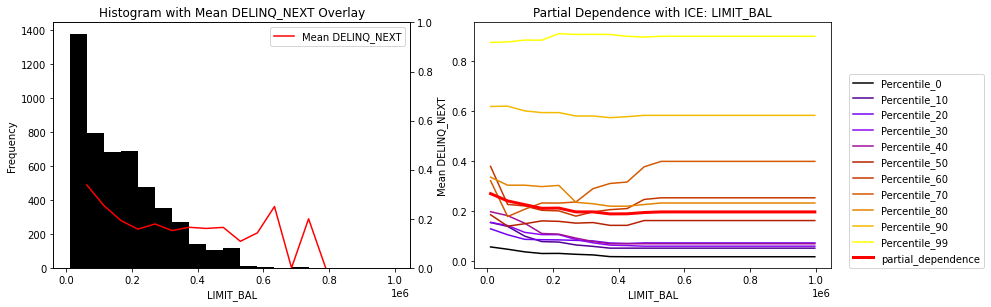

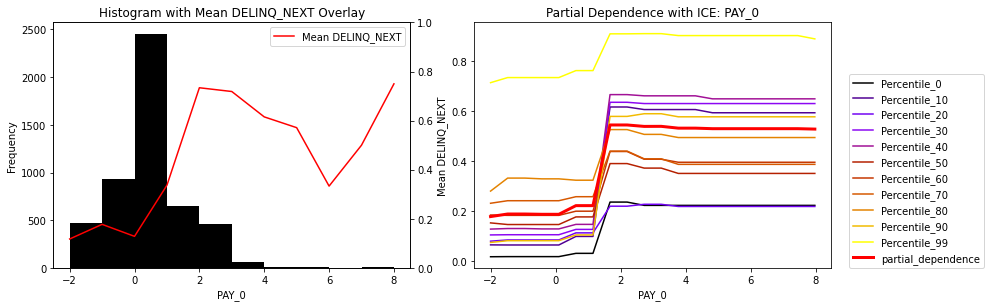

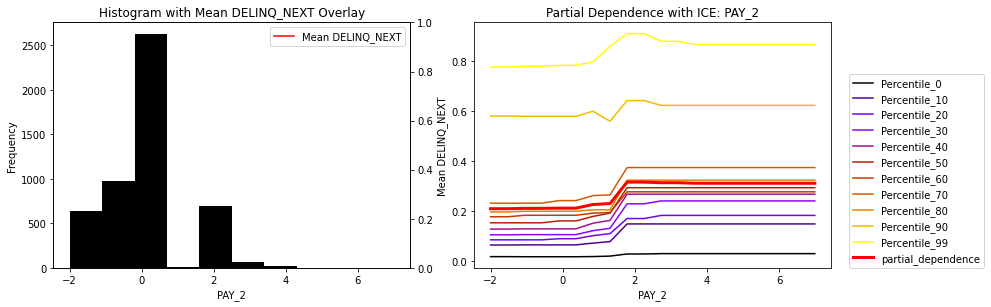

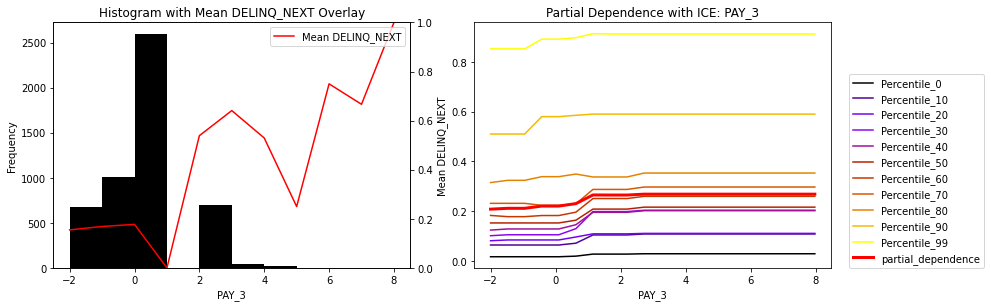

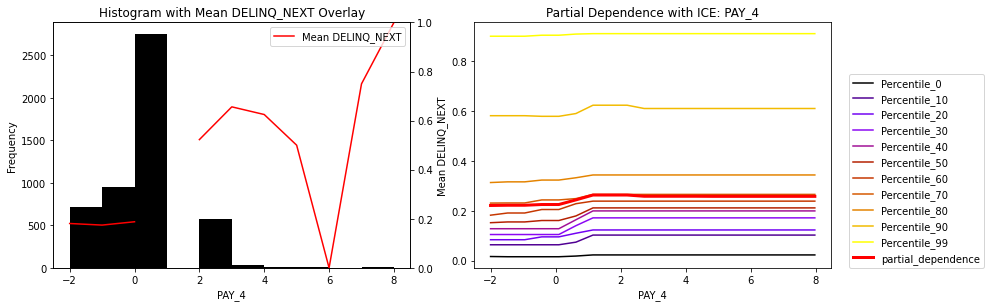

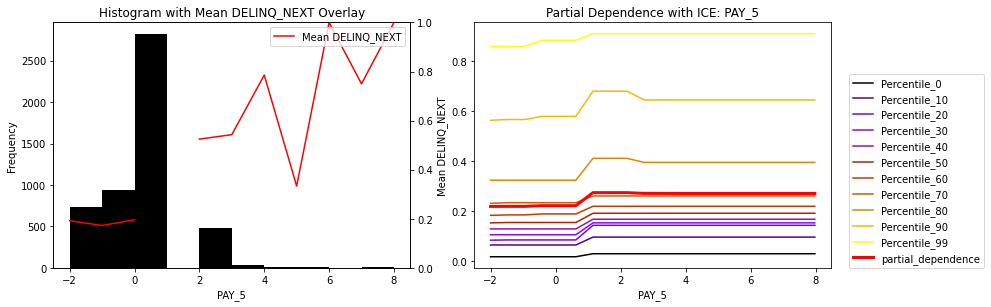

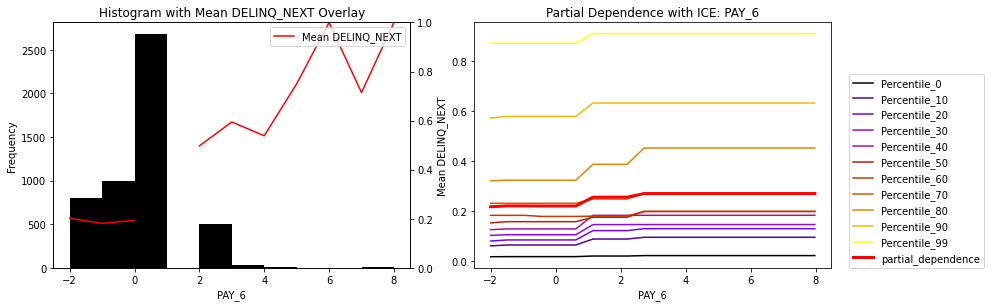

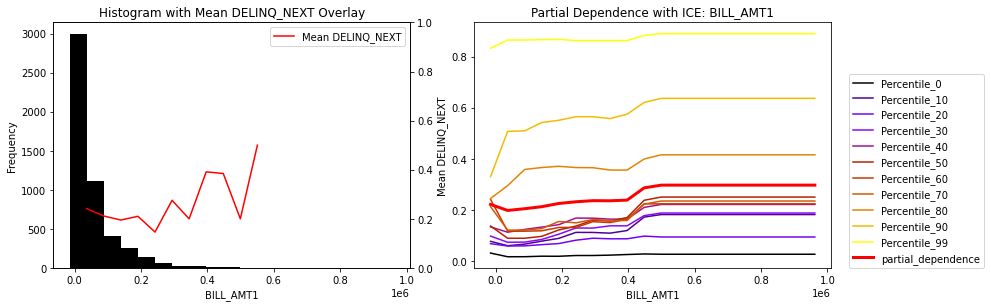

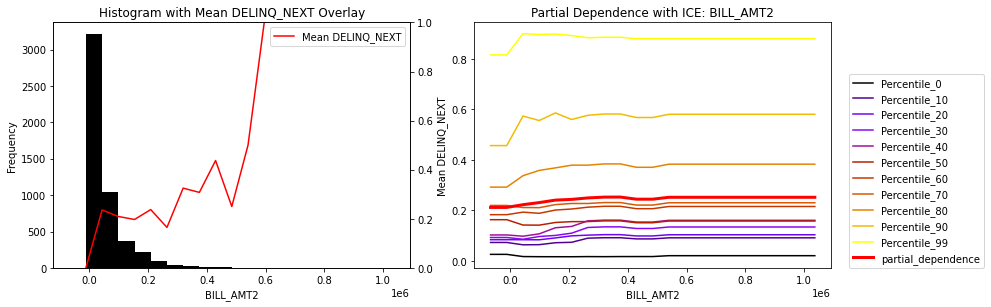

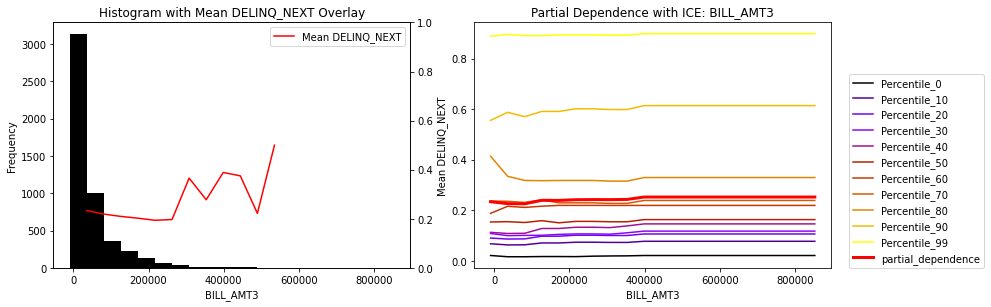

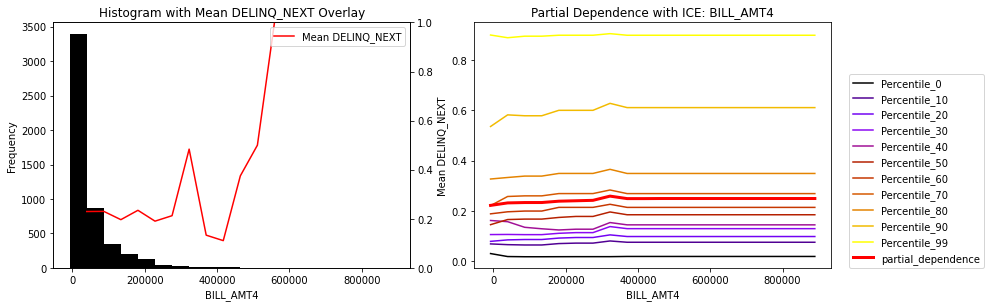

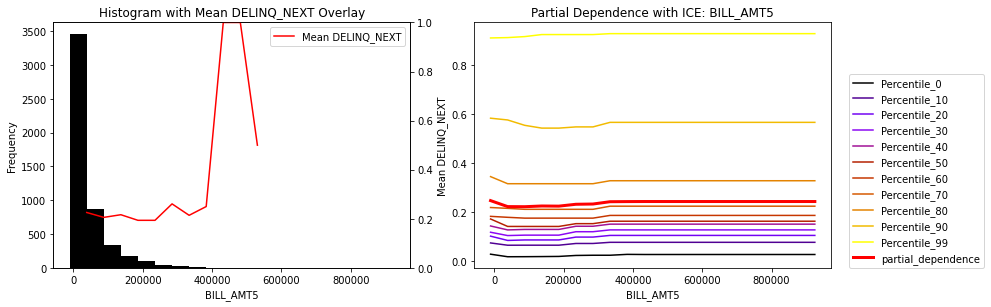

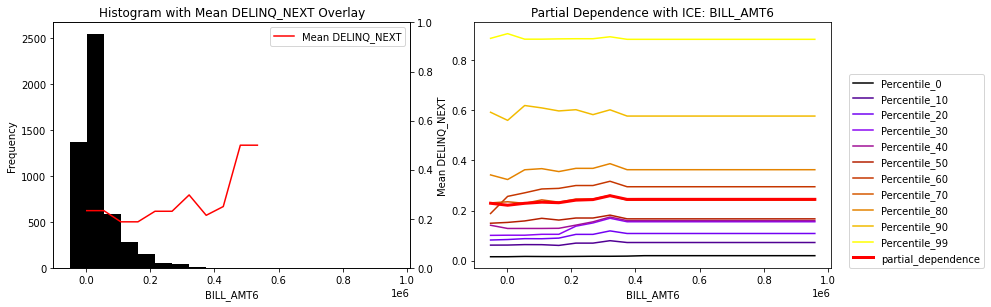

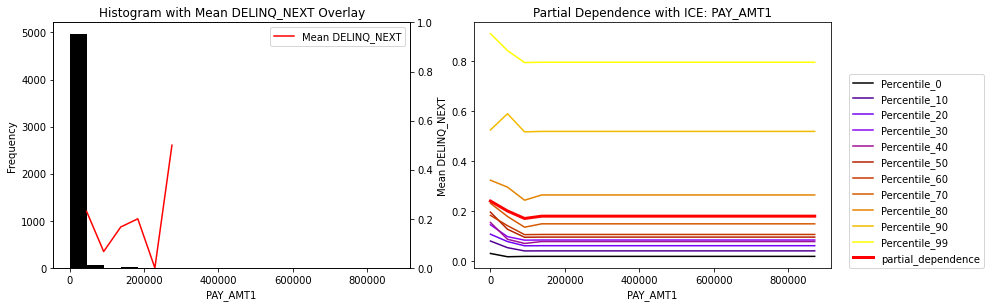

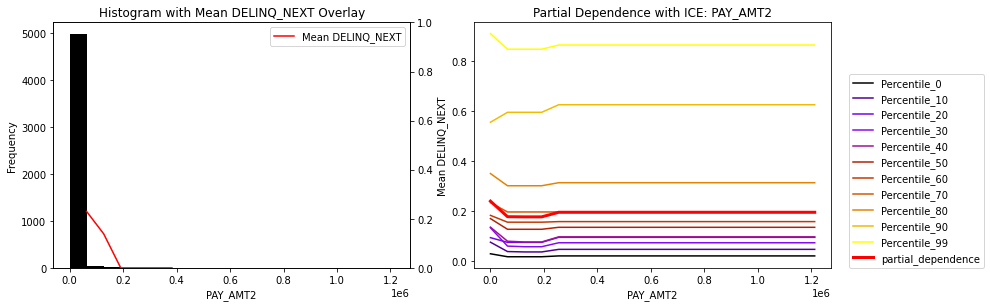

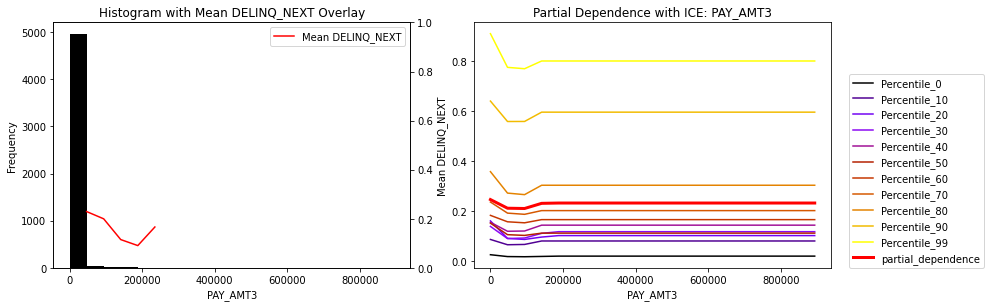

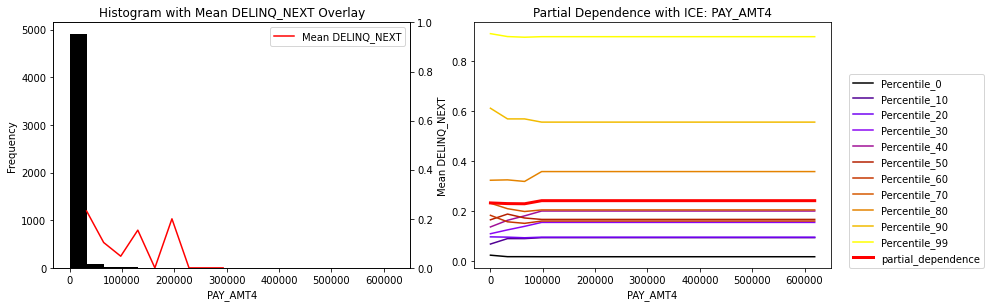

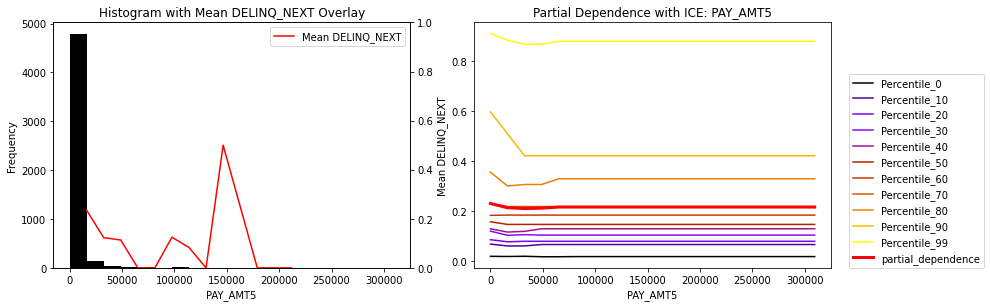

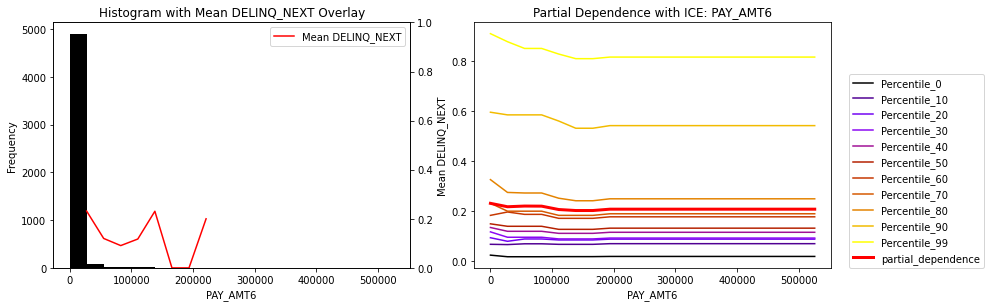

In [42]:
from hrml_book import explain

unconstrained_predict = lambda data: model_unconstrained.predict(xgb.DMatrix(data[features], 
                                                                             label=data[target])) 
constrained_predict = lambda data: model_constrained.predict(xgb.DMatrix(data[features], 
                                                                         label=data[target])) 

for feature in features:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features].copy(),
                                 y=valid[target].copy(),
                                 predict=unconstrained_predict)

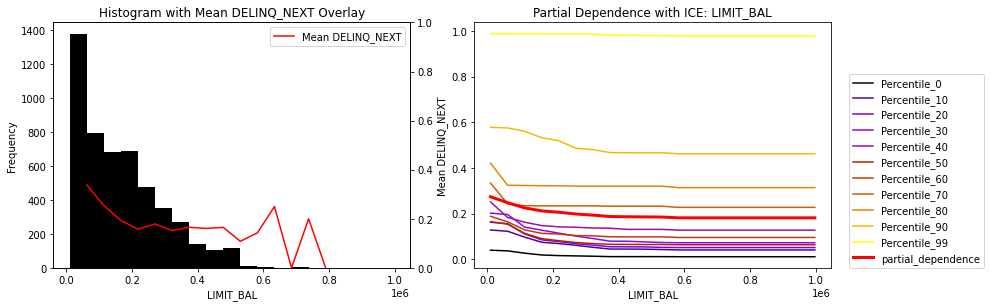

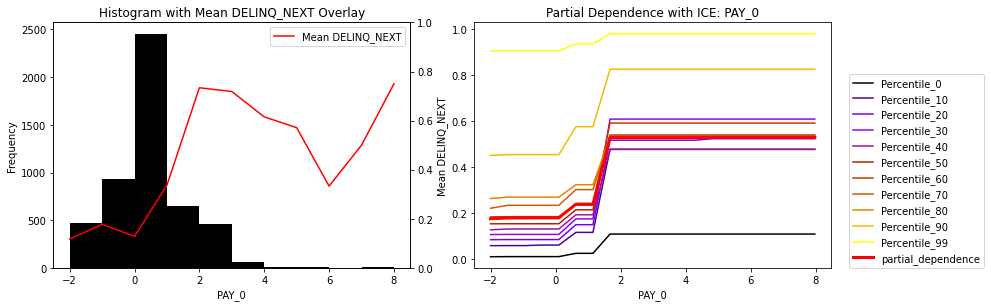

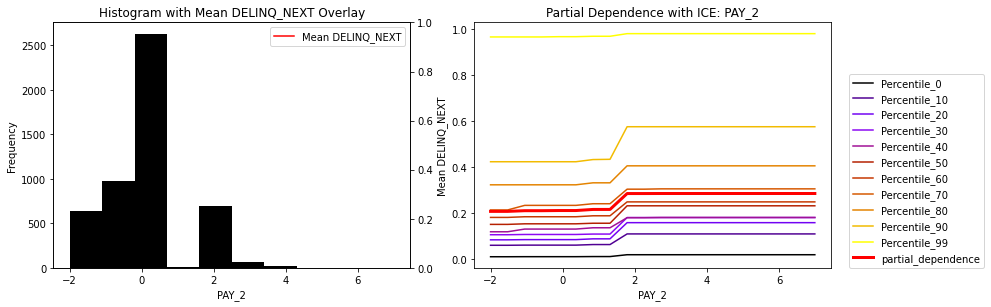

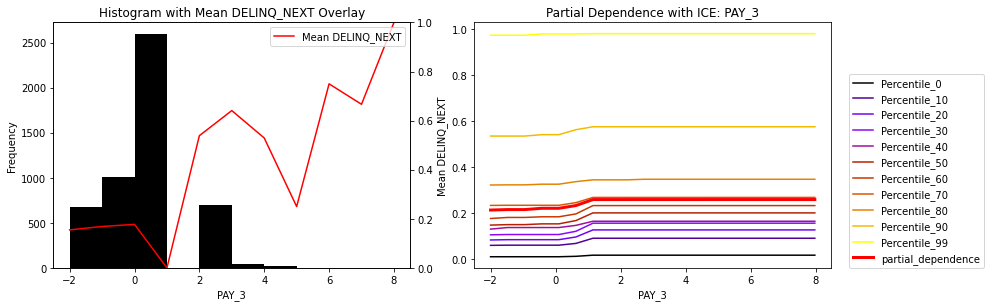

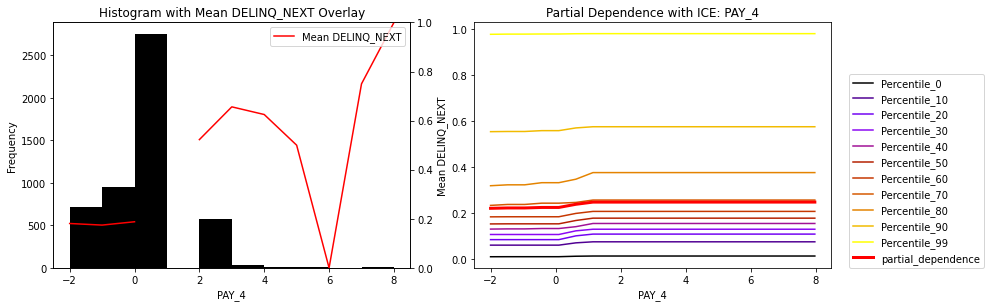

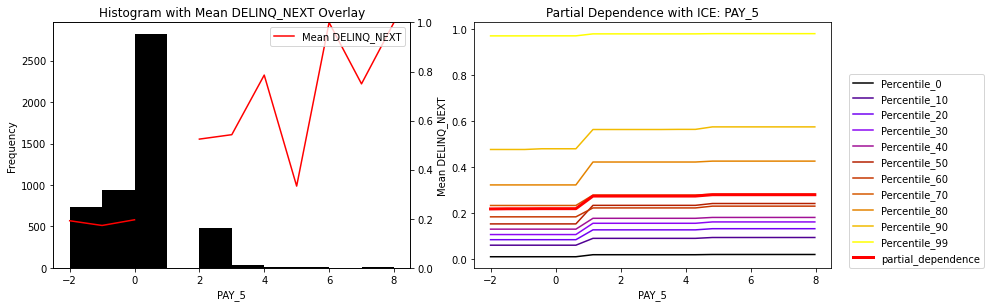

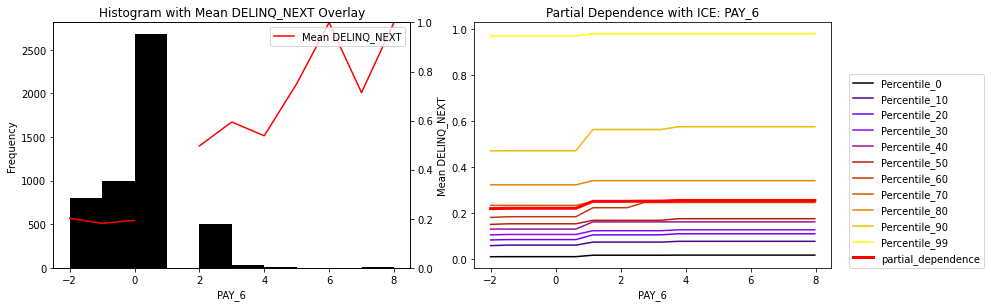

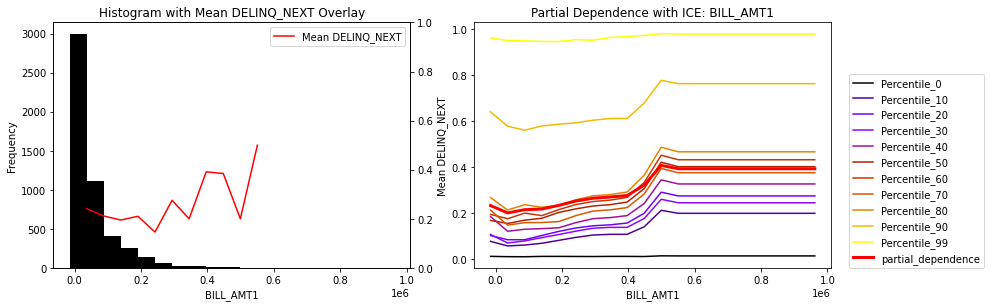

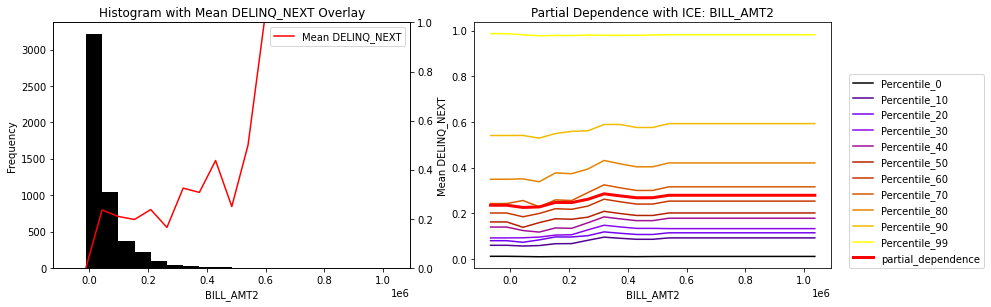

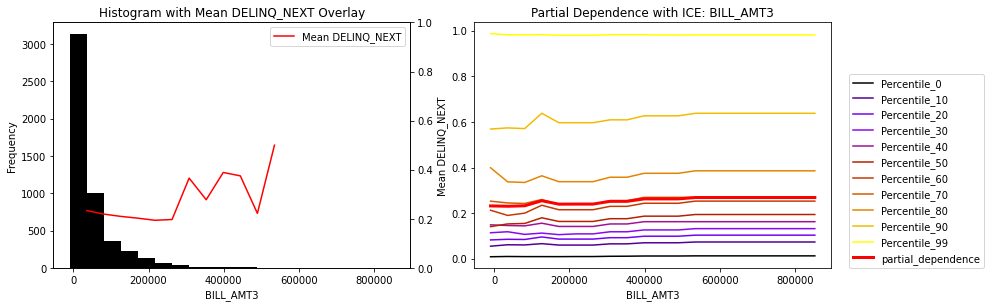

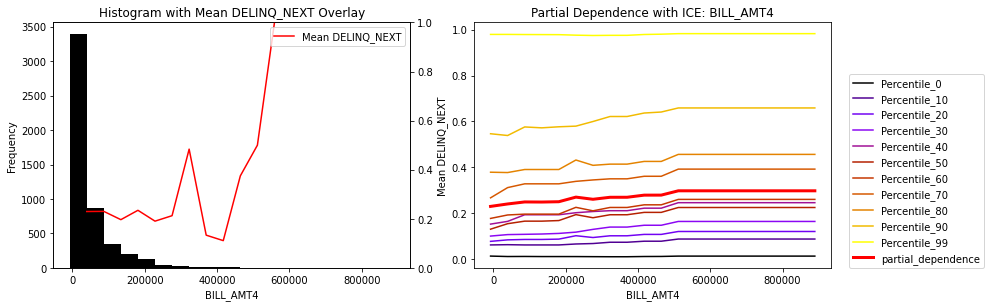

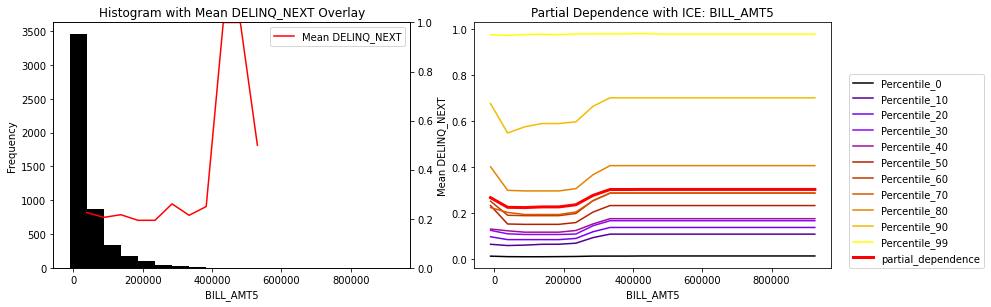

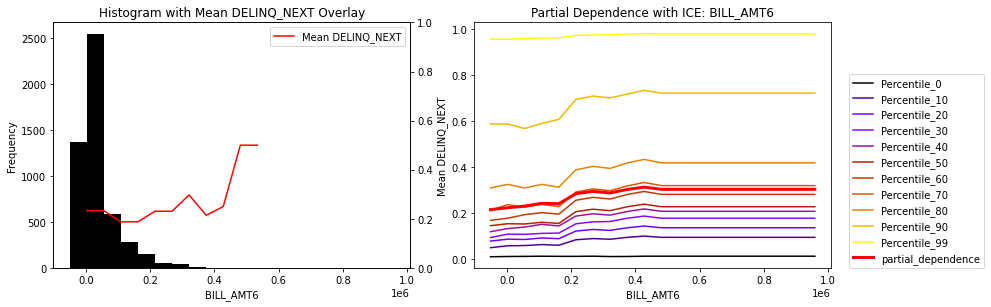

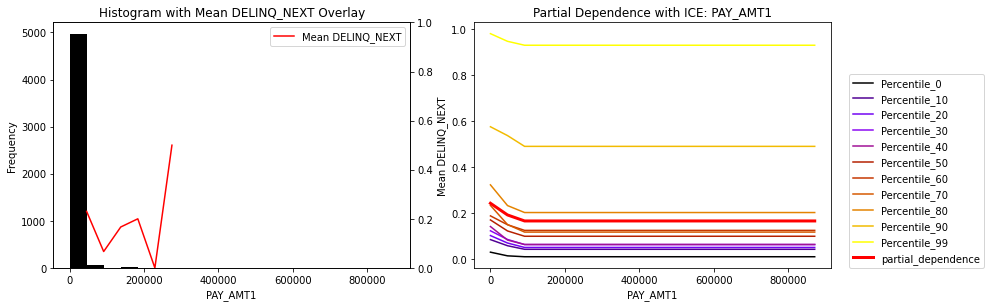

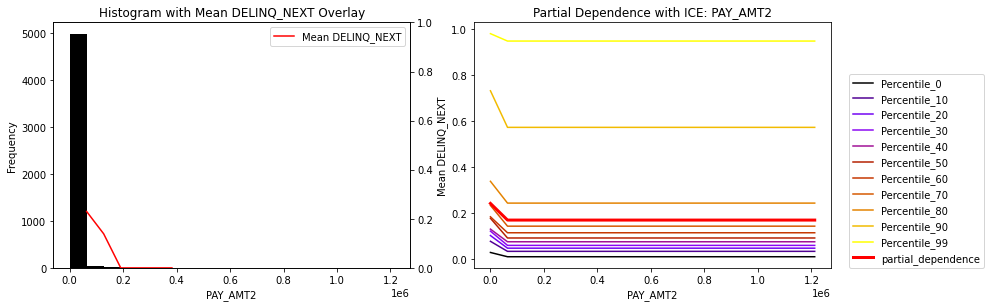

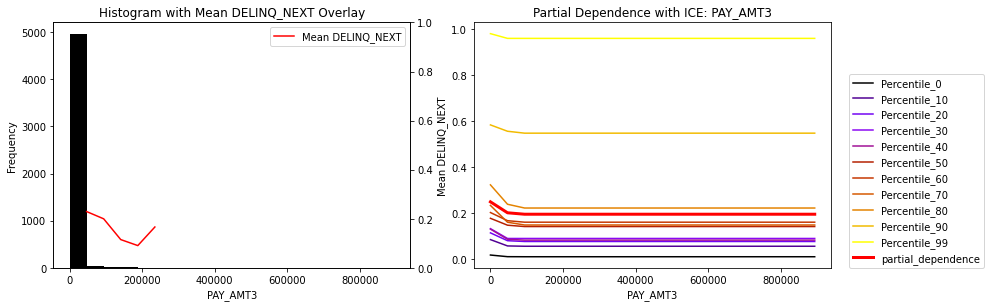

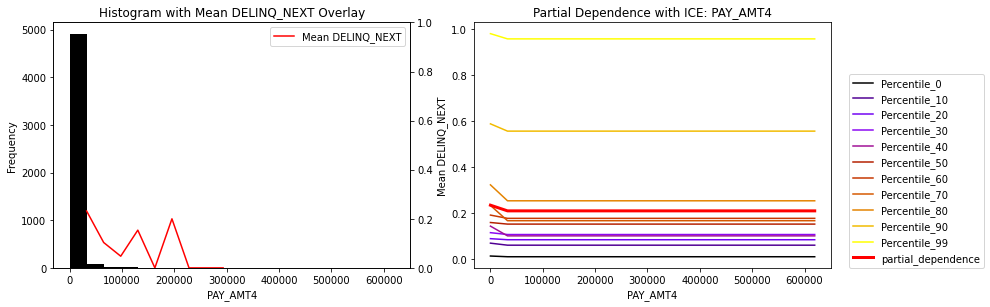

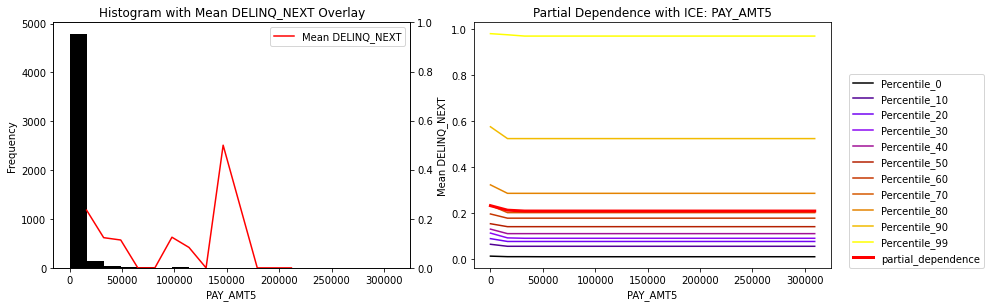

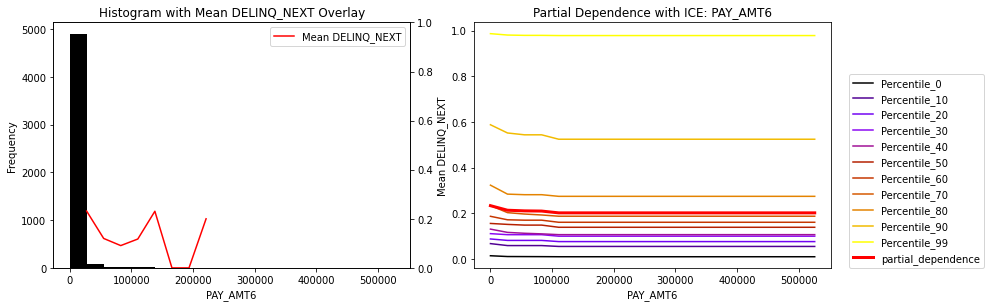

In [43]:
for feature in features:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features],
                                 y=valid[target],
                                 predict=constrained_predict)

## <a name="decision-tree-surrogate"></a>3. Decision Tree Surrogate Models as an Explanation Technique

### Train a Surrogate Model for the Constrained Model

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

surrogate_model_params = {'max_depth': 4,
                         'random_state': seed}
surrogate_model_constrained = DecisionTreeRegressor(**surrogate_model_params).fit(train[features], 
                                                                                  model_constrained.predict(dtrain))

### Assess Surrogate Model Fidelity Through Cross-Validation

In [45]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

cross_validator = KFold(n_splits=5)
cv_error = []
for train_index, test_index in cross_validator.split(train):
    train_k = train.iloc[train_index]
    test_k = train.iloc[test_index]
    
    dtrain_k = xgb.DMatrix(train_k[features], 
                           label=train_k[target])
    dtest_k = xgb.DMatrix(test_k[features], 
                          label=test_k[target])
    
    surrogate_model = DecisionTreeRegressor(**surrogate_model_params).fit(train_k[features], 
                                                                      model_constrained.predict(dtrain_k))
    r2 = r2_score(y_true=model_constrained.predict(dtest_k), 
                  y_pred=surrogate_model.predict(test_k[features]))
    cv_error += [r2]

for i, r2 in enumerate(cv_error):
    print(f"R2 value for fold {i}: {np.round(r2, 3)}")

print(f"\nStandard deviation of errors: {np.round(np.std(cv_error), 5)}")


R2 value for fold 0: 0.895
R2 value for fold 1: 0.899
R2 value for fold 2: 0.914
R2 value for fold 3: 0.891
R2 value for fold 4: 0.896

Standard deviation of errors: 0.00796


### Visualize Surrogate Models for the Constrained and Unconstrained Models

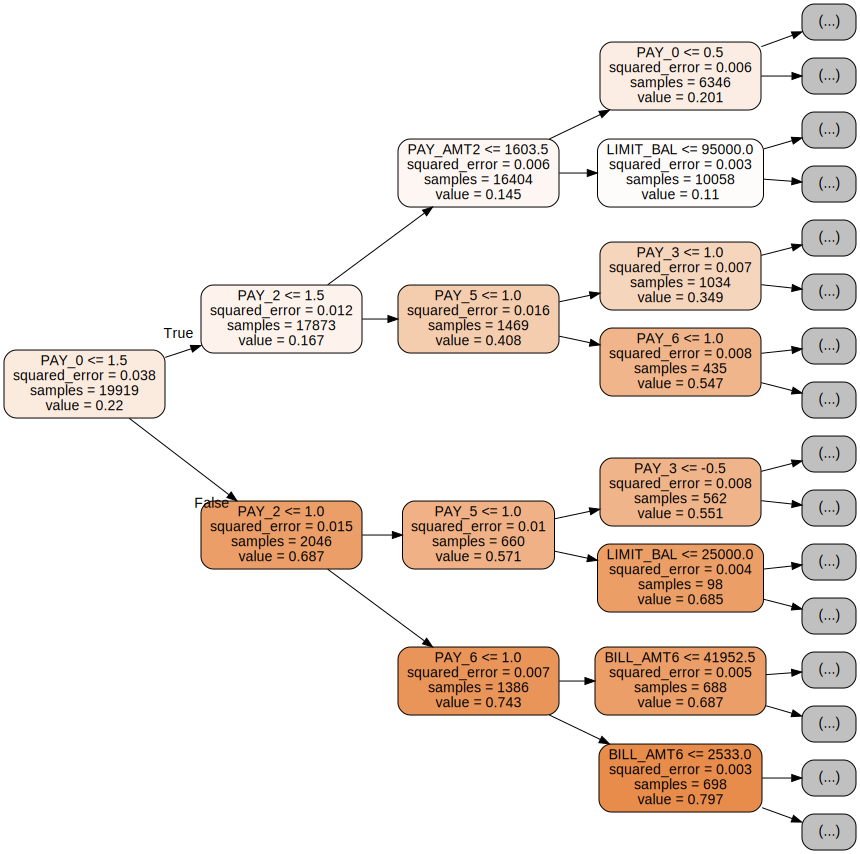

In [46]:
import graphviz

dot_data = tree.export_graphviz(surrogate_model_constrained, 
                                max_depth=3,
                                rounded=True,
                                out_file=None, 
                                feature_names=features,  
                                filled=True,
                                rotate=True)

graph = graphviz.Source(dot_data, format="png") 
graph

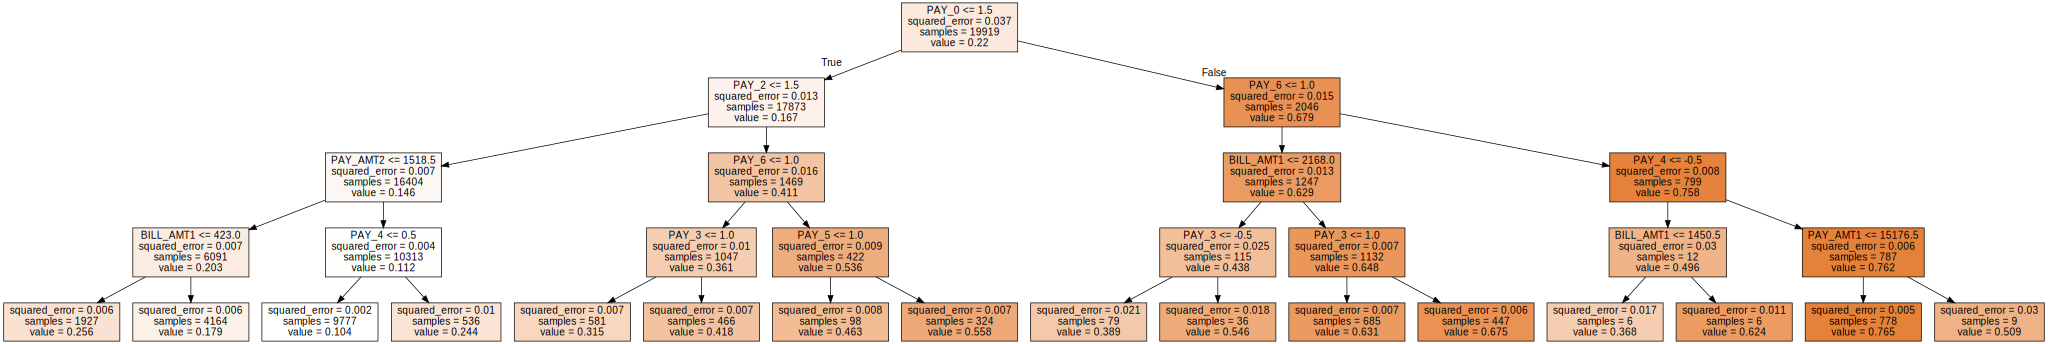

In [47]:
surrogate_model_unconstrained = DecisionTreeRegressor(**surrogate_model_params).fit(train[features], 
                                                                                    model_unconstrained.predict(dtrain))
dot_data = tree.export_graphviz(surrogate_model_unconstrained, 
                                out_file=None, 
                                feature_names=features,  
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

## <a name="shapley"></a>4. Shapley Value Explanations 

### Compute Explanations and Generate Exploratory Visualizations

In [48]:
import shap

# First, we'll compute local explanations without providing a reference distribution. For a discussion of these parameters
#  and the following analysis, see the text.
explainer = shap.TreeExplainer(model=model_constrained,
                               data=None, 
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

shap_values = explainer(train[features])

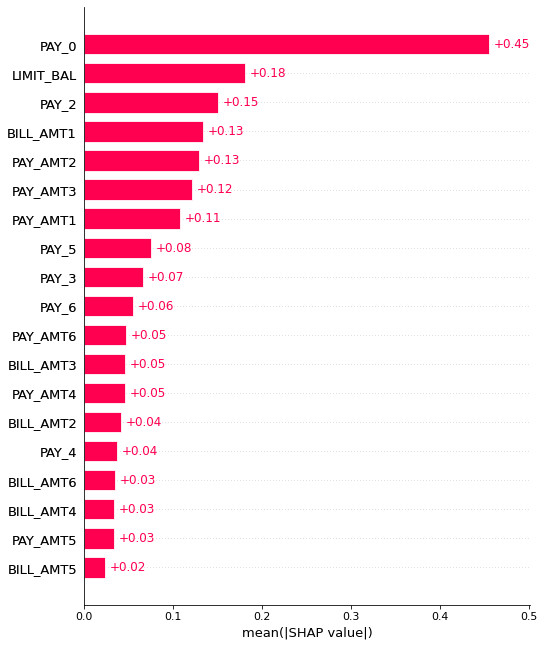

In [49]:
shap.plots.bar(shap_values, max_display=len(features))

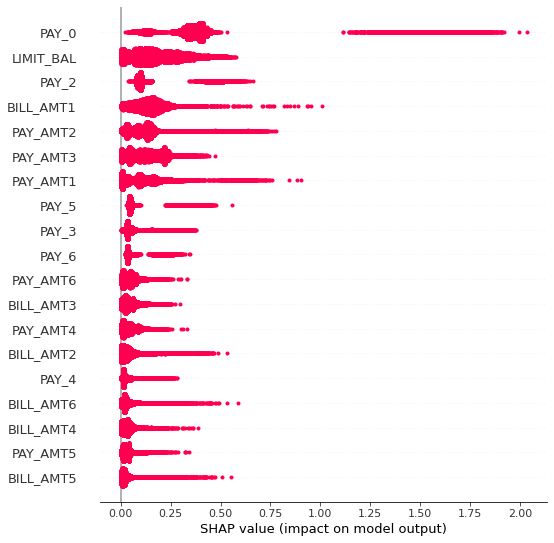

In [50]:
# Use a beeswarm for a richer version of the above plot.
fig = plt.figure()
shap.plots.beeswarm(shap_values.abs, color="shap_red", max_display=len(features))

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
 53%|█████▎    | 10/19 [01:10<01:08,  7.63s/it]No/low signal found from feature 9 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
20it [02:14,  7.49s/it]


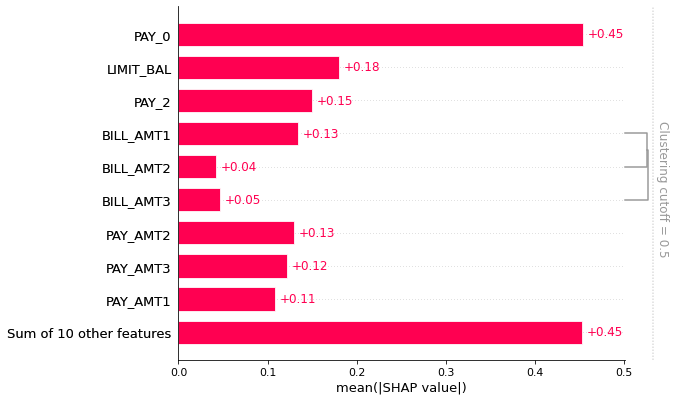

In [51]:
# Cluster redundant features. See the SHAP documentation for more details
clustering = shap.utils.hclust(train[features], train[target])
shap.plots.bar(shap_values, clustering=clustering)

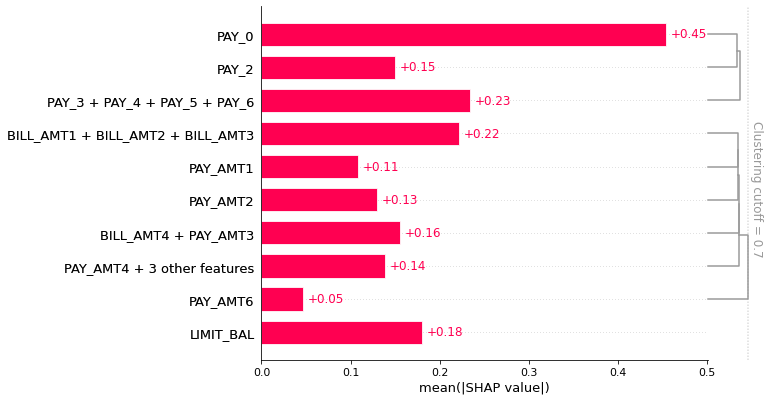

In [52]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.7)

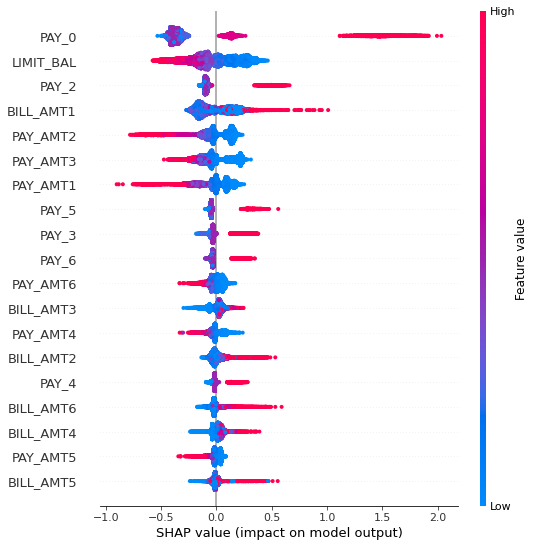

In [53]:
shap.plots.beeswarm(shap_values, max_display=len(features))

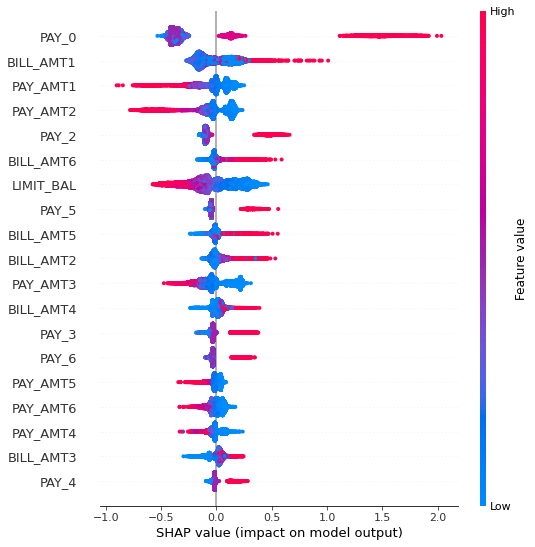

In [54]:
# Order by max(abs(shap_values)) to emphasize rare-but-high-magnitude effects, rather than overall feature importance.
shap.plots.beeswarm(shap_values, max_display=len(features), order=shap_values.abs.max(0))

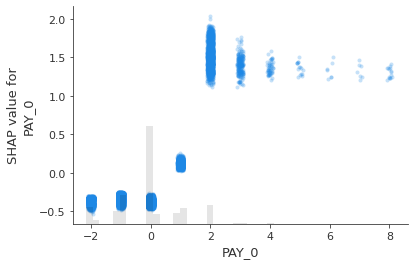

In [55]:
# shap scatter plots can be compared against PD/ICE plots.

fig, ax = plt.subplots()
shap.plots.scatter(shap_values[:,'PAY_0'], alpha=0.25, ax=ax)

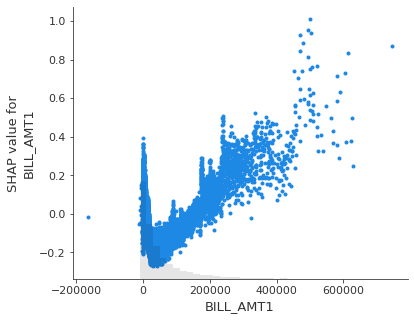

In [56]:
shap.plots.scatter(shap_values[:,'BILL_AMT1'])

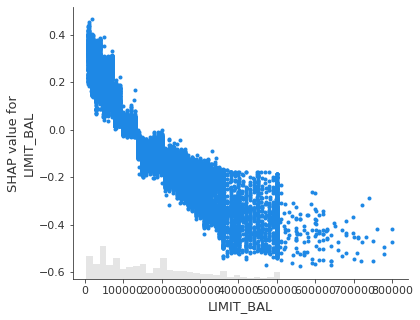

In [57]:
shap.plots.scatter(shap_values[:,'LIMIT_BAL'])

### Identify Observations that get Different Treatment under Different shap Parameterizations


In [58]:
explainer_interventional = shap.TreeExplainer(model=model_constrained,
                                              data=train[features], 
                                              model_output='raw',
                                              feature_perturbation='interventional')

shap_values_interventional = explainer_interventional(train[features])

 99%|===================| 19792/19919 [01:21<00:00]       

In [59]:
explainer_tpd = shap.TreeExplainer(model=model_constrained,
                                   feature_perturbation='tree_path_dependent')

shap_values_tpd = explainer_tpd(train[features])

In [60]:
train['pred'] = model_constrained.predict(dtrain)
approved_applicants = train.loc[train['pred'] < 0.1]
explainer_approved = shap.TreeExplainer(model=model_constrained,
                                        data=approved_applicants[features], 
                                        model_output='raw',
                                        feature_perturbation='interventional')

shap_values_approved = explainer_approved(train[features])

 99%|===================| 19736/19919 [01:12<00:00]       

In [61]:
# We seek observations whose shap values are most different under the 'Approved' and 
#  'Tree Path Dependent' parameterizations. We'll do this by maximizing the 1-distance
#  between the shaps after correcting for the different base values.

# Including the base values ensures that the shaps sum to the same value.

shaps_approved_shifted = shap_values_approved.values + (shap_values_approved.base_values[0]/len(features))
shaps_tpd_shifted = shap_values_tpd.values + (shap_values_tpd.base_values[0]/len(features))

diff_shaps = shaps_tpd_shifted - shaps_approved_shifted

biggest_diff_idx = np.argmax(np.abs(diff_shaps).mean(axis=1))

# Look at the observation that sees the largest change in their shap values. Notice that they
#  received a predicted value of 0.395 - this was a rejected applicant.
train.iloc[biggest_diff_idx]

ID             17826.000000
LIMIT_BAL      50000.000000
SEX                1.000000
RACE               2.000000
EDUCATION          2.000000
MARRIAGE           2.000000
AGE               25.000000
PAY_0             -2.000000
PAY_2             -2.000000
PAY_3             -2.000000
PAY_4             -2.000000
PAY_5             -2.000000
PAY_6             -2.000000
BILL_AMT1      -1587.000000
BILL_AMT2      -5174.000000
BILL_AMT3      -2587.000000
BILL_AMT4      -2587.000000
BILL_AMT5      -2587.000000
BILL_AMT6      -2587.000000
PAY_AMT1           0.000000
PAY_AMT2           0.000000
PAY_AMT3           0.000000
PAY_AMT4           0.000000
PAY_AMT5           0.000000
PAY_AMT6           0.000000
DELINQ_NEXT        1.000000
pred               0.432445
Name: 17825, dtype: float64

In [62]:
# Identify the top ten observations with the largest differences

ind = np.argpartition(np.abs(diff_shaps).mean(axis=1), -10)[-10:]

top_N = train.iloc[ind]
top_N['ind'] = ind
top_N

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT,pred,ind
1829,1830,50000,1,2.0,2,2,24,-1,-1,-2,...,-3650,0,0,0,0,0,0,0,0.365065,1223
29455,29456,20000,1,3.0,2,2,30,1,-2,-2,...,-2250,0,0,0,0,0,4000,0,0.466660,19554
14741,14742,50000,1,4.0,3,2,31,-1,-1,-1,...,-3300,1000,0,0,0,0,0,1,0.350144,9753
1795,1796,200000,1,4.0,1,2,34,1,-2,-2,...,-11060,0,0,0,0,0,0,0,0.345957,1203
17825,17826,50000,1,2.0,2,2,25,-2,-2,-2,...,-2587,0,0,0,0,0,0,1,0.432445,11803
24674,24675,30000,1,3.0,2,2,35,2,2,-2,...,-1620,0,0,0,0,1620,900,1,0.826908,16382
27554,27555,40000,1,4.0,2,1,55,1,-2,-2,...,-2100,0,0,0,0,0,0,1,0.522753,18293
27354,27355,120000,1,4.0,3,2,31,1,-2,-2,...,-2390,3,0,0,0,0,0,1,0.553378,18160
14178,14179,90000,2,4.0,2,1,41,1,1,-2,...,-2364,0,0,0,0,0,0,1,0.493553,9379
26252,26253,240000,2,3.0,1,2,28,-2,-2,-2,...,-253,0,0,0,0,1823,0,0,0.156861,17404


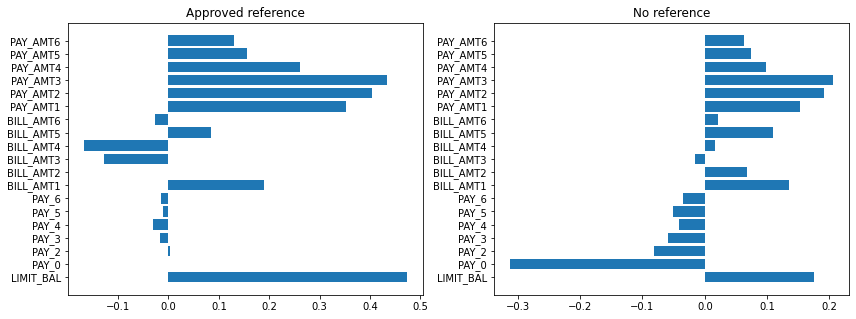

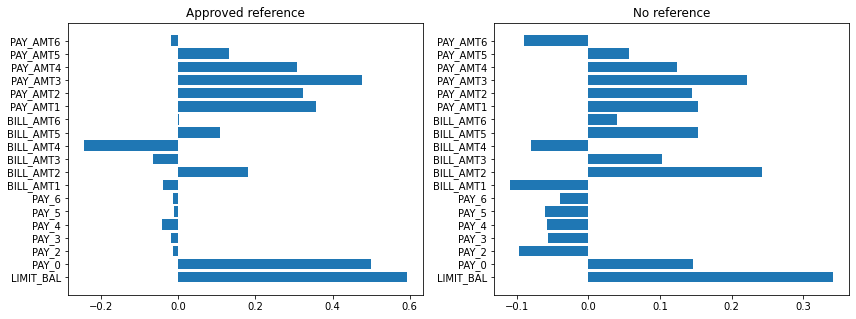

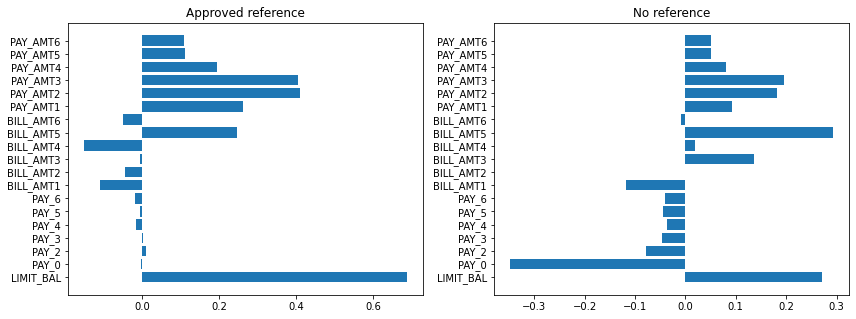

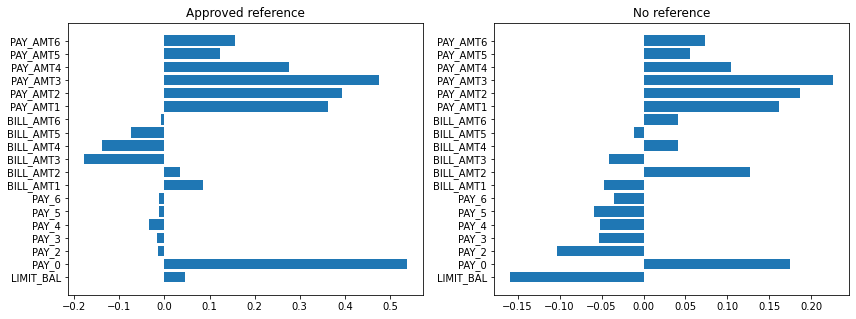

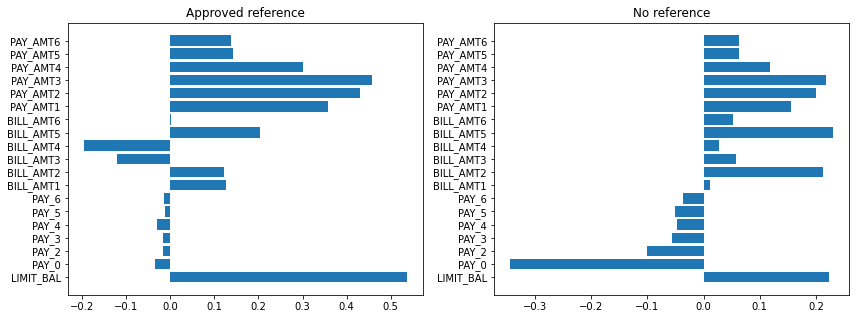

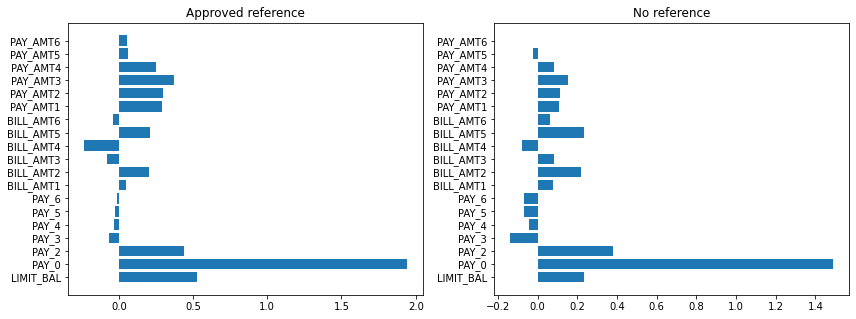

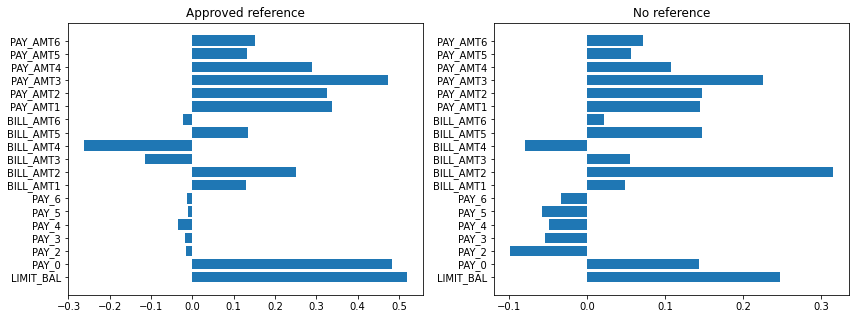

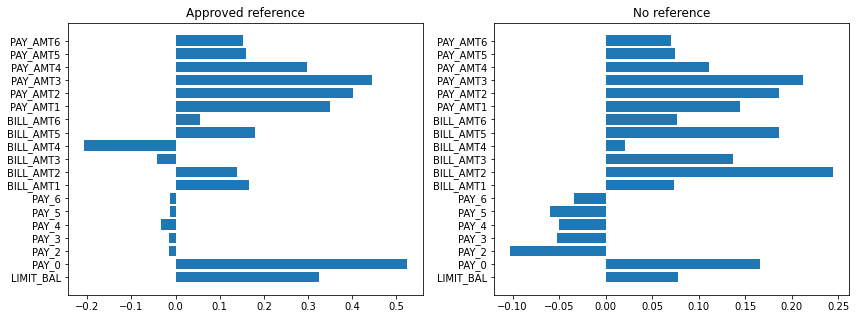

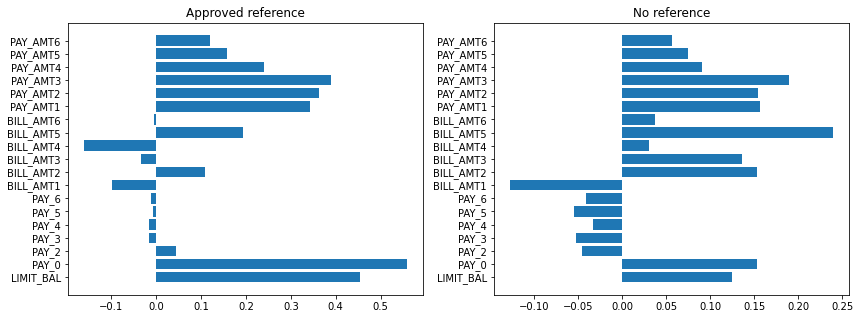

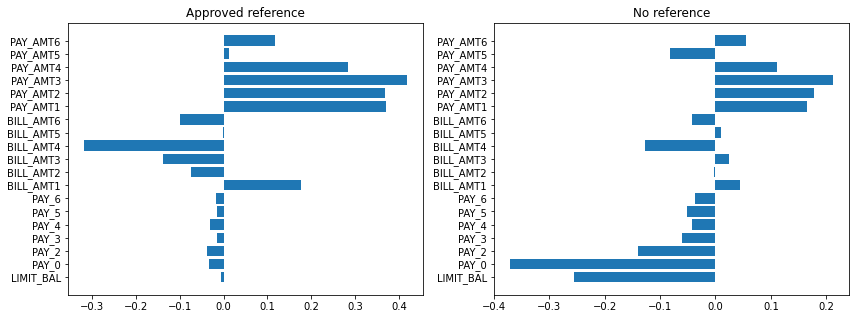

In [63]:
for obs in ind:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    _ = axs[0].barh(features, shap_values_approved.values[obs, :])
    _ = axs[0].set_title("Approved reference")

    _ = axs[1].barh(features, shap_values_tpd.values[obs, :])
    _ = axs[1].set_title("No reference")